In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.interpolate import CubicSpline
from matplotlib.font_manager import FontProperties
from itertools import product
from sklearn.metrics import r2_score
import csv
from vmd import VMD
from envelope import spline_envelope

In [119]:
# adjusted R-squared
def r2_score_adjusted(y, y_pred, featurecount):
    n = len(y)
    return 1 - (1-r2_score(y, y_pred)) * (n-1)/(n-featurecount-1)

# AIC
def calculate_aic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    aic = n * np.log(sse / n) + 2 * k
    return aic

# BIC
def calculate_bic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    bic = n * np.log(sse / n) + k * np.log(n)
    return bic

# импорт временного ряда

In [120]:
# linux path
# path1 = './'
# path2 = '/'

# windows path
path1 = '.\\'
path2 = '\\'

In [121]:
DS = pd.read_csv("KwhConsumptionBlower78_1.csv", decimal=',')
DS['datetime'] = pd.to_datetime(DS['TxnDate'].astype(str) + ' ' + DS['TxnTime'].astype(str))
DS['Consumption'] = pd.to_numeric(DS['Consumption'])
DS.set_index("datetime", inplace=True)
DS.dropna(inplace=True)
TS = DS['Consumption']
TS = TS.sort_index()
TS

datetime
2022-01-01 00:22:28     1.030
2022-01-01 00:42:33     0.904
2022-01-01 01:01:51     0.904
2022-01-01 01:41:48     1.850
2022-01-01 02:22:52     1.878
                        ...  
2022-01-20 22:04:41     5.732
2022-01-20 22:26:36     5.928
2022-01-20 22:47:26     6.432
2022-01-20 23:27:57    13.092
2022-01-20 23:47:55     6.788
Name: Consumption, Length: 1228, dtype: float64

In [122]:
index = TS.index
index

DatetimeIndex(['2022-01-01 00:22:28', '2022-01-01 00:42:33',
               '2022-01-01 01:01:51', '2022-01-01 01:41:48',
               '2022-01-01 02:22:52', '2022-01-01 02:47:00',
               '2022-01-01 03:06:30', '2022-01-01 03:27:40',
               '2022-01-01 03:47:47', '2022-01-01 04:07:36',
               ...
               '2022-01-20 20:21:01', '2022-01-20 20:44:24',
               '2022-01-20 21:03:39', '2022-01-20 21:24:09',
               '2022-01-20 21:43:55', '2022-01-20 22:04:41',
               '2022-01-20 22:26:36', '2022-01-20 22:47:26',
               '2022-01-20 23:27:57', '2022-01-20 23:47:55'],
              dtype='datetime64[ns]', name='datetime', length=1228, freq=None)

In [123]:
k = 4 # количество декомпозиций
f = TS[::].values # значения временного ряда, в дальнейшем - вычеты
u = np.zeros(k, dtype=list) # декомпозиции
low = np.zeros(k, dtype=list) # верхние огибающие
high = np.zeros(k, dtype=list) # нижние огибающие


for i in range(0,k):
    low_envelope, high_envelope = spline_envelope(f,dmin=1,dmax=1)
    low[i] = low_envelope
    high[i] = high_envelope
    # u[i] = (high_envelope + low_envelope)/2
    u[i] = f - (high_envelope + low_envelope)/2
    f = f - u[i]


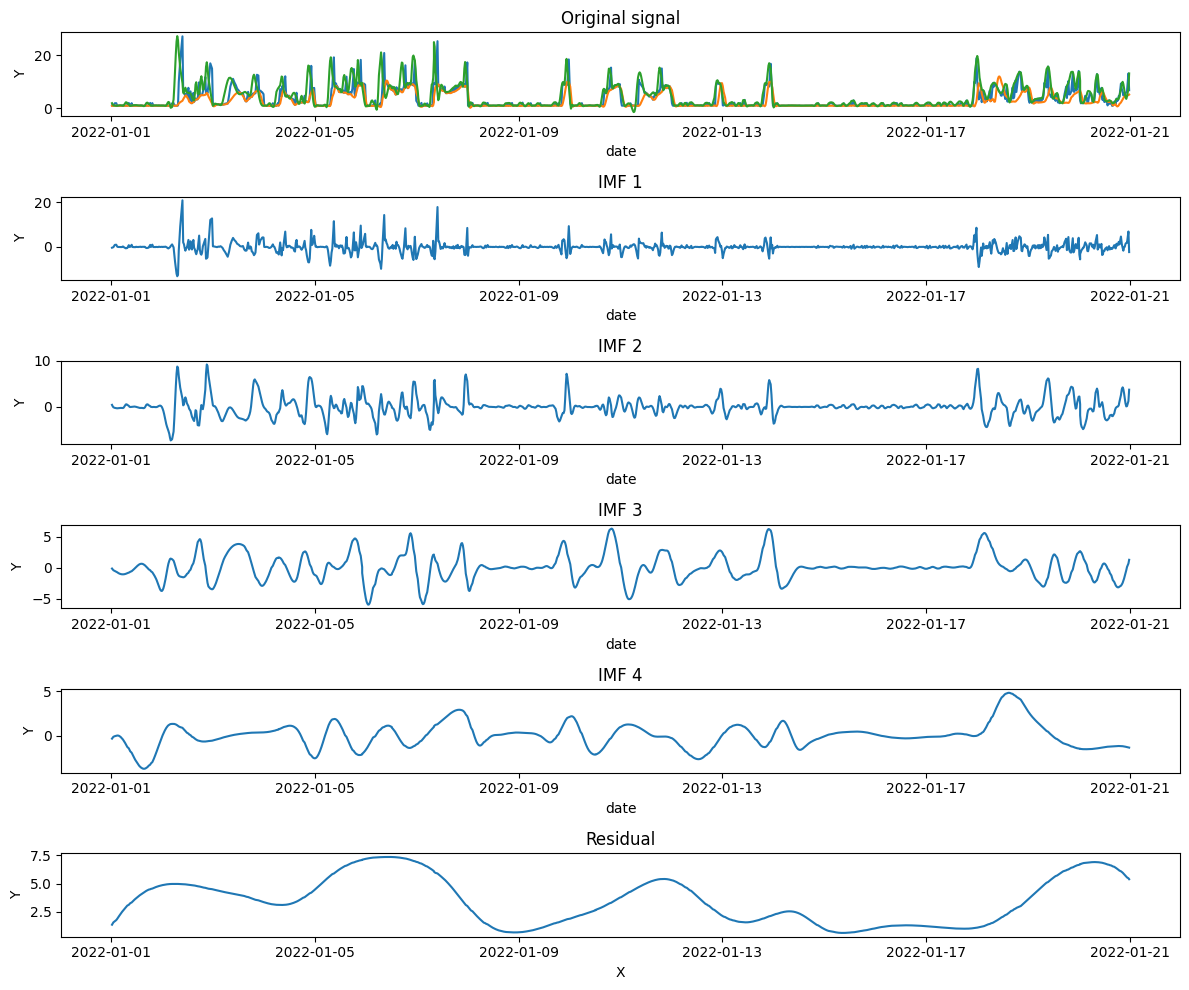

In [124]:
fig, axs = plt.subplots(figsize=(12,10), nrows=k+2)

# plt.subplot(2,1,1)
axs[0].set(xlabel = 'date', ylabel='Y')
axs[0].plot(index, TS[::].values)
axs[0].plot(index, low[0])
axs[0].plot(index, high[0])
axs[0].set_title('Original signal')

# plt.subplot(2,1,2)
for i in range(k):
    axs[i+1].plot(index, u[i])
    axs[i+1].set_title(f'IMF {i+1}')
    axs[i+1].set(xlabel = 'date', ylabel='Y')

# plt.subplot(2,2,2)
axs[k+1].plot(index, f)
plt.title('Residual')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

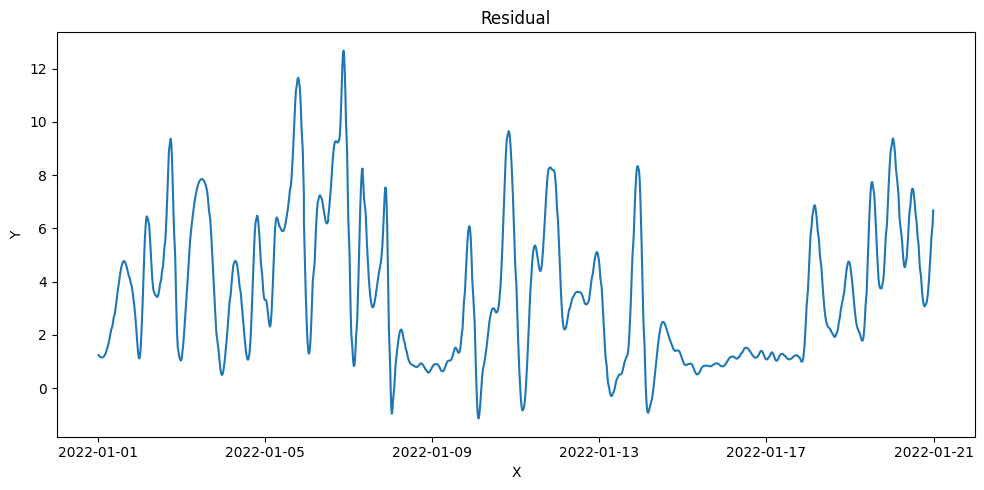

In [125]:
fig, axs = plt.subplots(figsize=(10,5), nrows=1)


sum_imfs = 0
for i in range(2,3):
    sum_imfs += u[i]

sum_imfs += f
# axs.plot(index, TS[::].values)
axs.plot(index, sum_imfs)
plt.title('Residual')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

In [126]:
Trend = f + u[3]
Component_of_TS = Trend[::]
Component_name = "Trend"
range_of_imfs = range(8)

Season = u[2]+u[1]
Component_of_TS = Season[::]
Component_name = "Season"
range_of_imfs = range(1,8)

Noise = u[0]
Component_name = "Noise"
range_of_imfs = range(10)
Component_of_TS = Noise[::]

# для частотного спектра
# Component_of_TS = np.abs(np.fft.rfft(Noise))

# тестовый анализ

In [104]:
filename="KwhConsumptionBlower-Trend.csv"
fields = ["Value",]
with open(filename, mode='w+', newline='') as file:
    array = csv.writer(file, delimiter='\n')
    array.writerows([["Value"],])
    array.writerows([Trend])

filename="KwhConsumptionBlower-Season.csv"
fields = ["Value",]
with open(filename, mode='w+', newline='') as file:
    array = csv.writer(file, delimiter='\n')
    array.writerows([["Value"],])
    array.writerows([Season])

filename="KwhConsumptionBlower-Noise.csv"
fields = ["Value",]
with open(filename, mode='w+', newline='') as file:
    array = csv.writer(file, delimiter='\n')
    array.writerows([["Value"],])
    array.writerows([Noise])

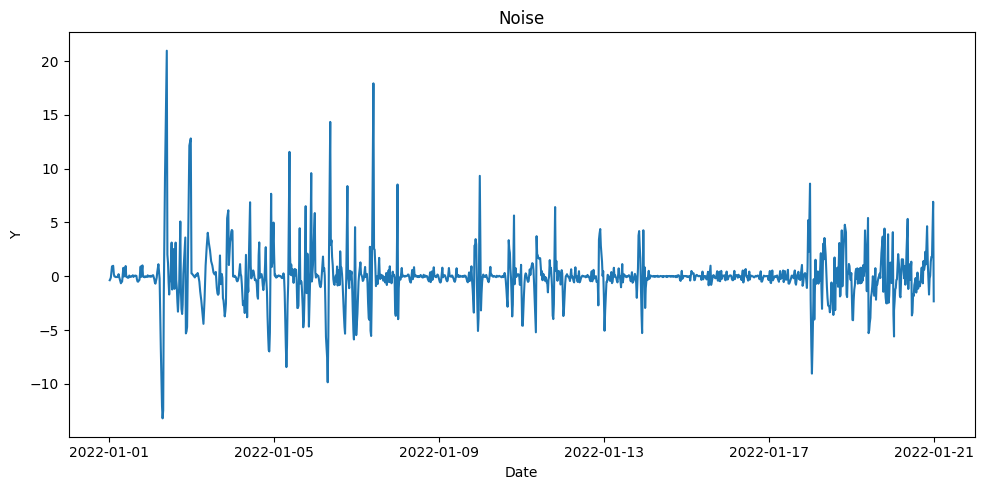

In [38]:
fig, axs = plt.subplots(figsize=(10,5), nrows=1)

# axs.plot(index, TS[::].values)
# axs.plot(index, Trend)
# plt.title('Trend')

# axs.plot(index, Season)
# plt.title('Season')

axs.plot(index, Noise)
plt.title('Noise')

plt.xlabel('Date')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

In [21]:
Trend

array([1.07081717, 1.2919509 , 1.48635979, ..., 4.30456868, 4.20004396,
       4.09018603], shape=(1228,))

In [575]:
alpha = 25000
DC = True
init = 10

K = 7
tau = 0
tol = 1e-6

In [576]:
imf, _, _ = VMD(TS, alpha=alpha, tau=tau, K=K, DC=DC, init=init, tol=tol)

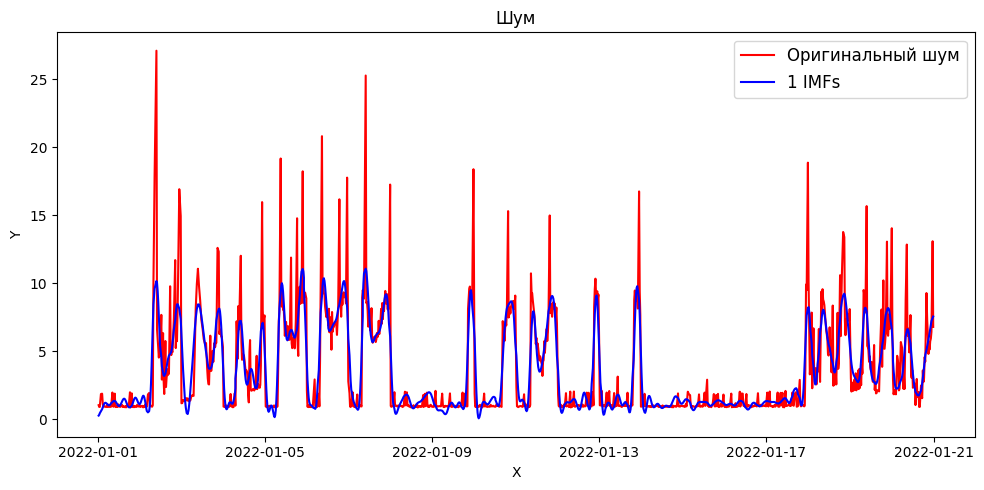

In [ ]:
fig, axs = plt.subplots(figsize=(10,5), nrows=1)

sum_imfs = 0
for i in range(K):
    sum_imfs += imf[i]

axs.plot(index, TS, color="#ff0000")
axs.plot(index, sum_imfs, color="#0000ff")
plt.title('Сигнал', fontsize=12)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Оригинальный сигнал', '1 IMFs'], prop=FontProperties(size=12))

plt.tight_layout()

In [565]:
Trend = f + u[3]
Component_of_TS = Trend[::]

In [558]:
alpha = 8000
DC = False
init = 10

K = 7
tau = 0
tol = 1e-6

In [559]:
imf, _, _ = VMD(TS, alpha=alpha, tau=tau, K=K, DC=DC, init=init, tol=tol)

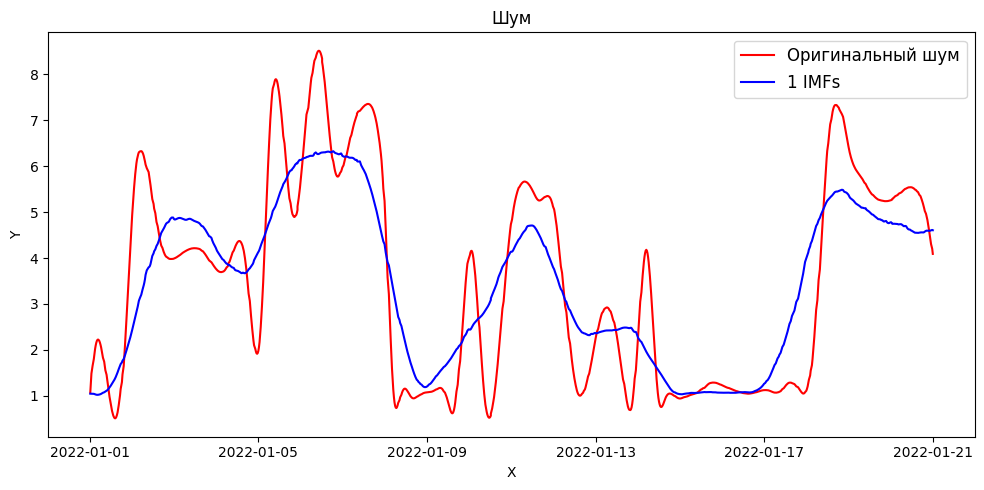

In [ ]:
fig, axs = plt.subplots(figsize=(10,5), nrows=1)

sum_imfs = 0
for i in range(1):
    sum_imfs += imf[i]

axs.plot(index, Component_of_TS, color="#ff0000")
axs.plot(index, sum_imfs, color="#0000ff")
plt.title('Тренд', fontsize=12)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Оригинальный тренд', '1 IMFs'], prop=FontProperties(size=12))

plt.tight_layout()

In [561]:
r2_score(sum_imfs, Component_of_TS)

0.5262001771569047

In [405]:
Season = u[2]+u[1]
Component_of_TS = Season[::]


In [503]:
alpha = 2500
DC = True
init = 5

K = 10
tau = 0
tol = 1e-6

In [504]:
imf, _, _ = VMD(TS, alpha=alpha, tau=tau, K=K, DC=DC, init=init, tol=tol)

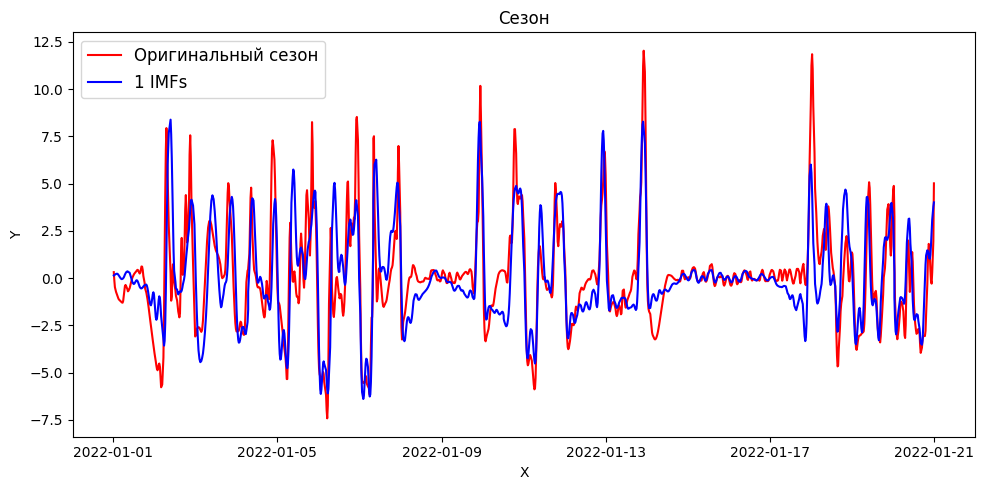

In [505]:
fig, axs = plt.subplots(figsize=(10,5), nrows=1)

sum_imfs = 0
for i in range(1, 6):
    sum_imfs += imf[i]

axs.plot(index, Component_of_TS, color="#ff0000")
axs.plot(index, sum_imfs, color="#0000ff")
plt.title('Сезон', fontsize=12)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Оригинальный сезон', '1 IMFs'], prop=FontProperties(size=12))

plt.tight_layout()

In [506]:
r2_score(sum_imfs, Component_of_TS)

0.46152365708182463

In [358]:
Noise = u[0]
Component_of_TS = Noise[::]

In [359]:
alpha = 5500
DC = False
init = 5
K = 10

tau = 0
tol = 1e-6

In [360]:
imf, _, _ = VMD(TS, alpha=alpha, tau=tau, K=K, DC=DC, init=init, tol=tol)

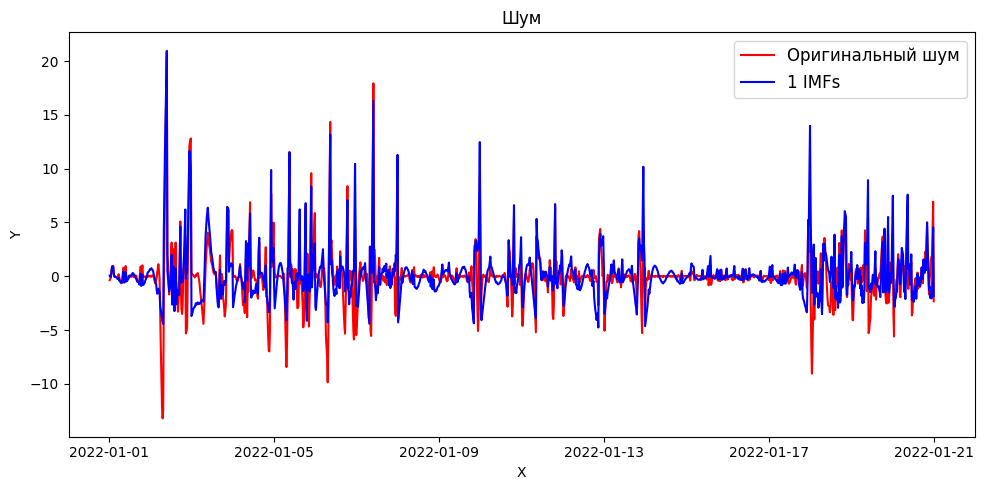

In [365]:
fig, axs = plt.subplots(figsize=(10,5), nrows=1)

sum_imfs = 0
for i in range(3):
    sum_imfs += imf[i]
residual = TS - sum_imfs


axs.plot(index, Component_of_TS, color="#ff0000")
axs.plot(index, residual, color="#0000ff")
plt.title('Шум', fontsize=12)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Оригинальный шум', '1 IMFs'], prop=FontProperties(size=12))

plt.tight_layout()

In [366]:
r2_score(residual, Component_of_TS)

0.4230440259866578

# декомпозиция временного ряда

In [127]:
alpha = (0, 500, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000)
init = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
DC = (False, True)
K = 10

tau = 0            #BY DEFAULT  
tol = 1e-6         #BY DEFAULT

featurecount = 6

In [128]:
best_metriks = {"Time Series": f"Dehli-Temerature", "R2": -np.inf, "R2_Adj": -np.inf, "AIC" : np.inf, "BIC": np.inf}

best_r2_params = ({"Time Series": f"Dehli-Temerature", "Metric": "R2", "K": 10, "alpha": 0, "DC": False, "init": 0, "IMFs" : "1"}) 
best_r2_adj_params = ({"Time Series": f"Dehli-Temerature", "Metric": "R2_Adj", "K": 10, "alpha": 0,  "DC": False, "init": 0, "IMFs" : "1"}) 
best_aic_params = ({"Time Series": f"Dehli-Temerature", "Metric": "AIC", "K": 10, "alpha": 0, "DC": False, "init": 0, "IMFs" : "1"}) 
best_bic_params = ({"Time Series": f"Dehli-Temerature", "Metric": "BIC", "K": 10, "alpha": 0, "DC": False, "init": 0, "IMFs" : "1"}) 



In [129]:
alpha_j = np.zeros(len(alpha)*len(init)*len(DC), dtype=int)
init_j = np.zeros(len(alpha)*len(init)*len(DC), dtype=int)
DC_j = np.zeros(len(alpha)*len(init)*len(DC), dtype=bool)

j = 0
for params_set in list(product(alpha, DC, init)):
    alpha_j[j] = params_set[0]
    DC_j[j] = params_set[1]
    init_j[j] = params_set[2]
    
    j+=1

In [ ]:
j=0
r2_list = np.zeros((len(alpha)*len(DC)*len(init), 2), dtype=float)
r2_adj_list = np.zeros((len(alpha)*len(DC)*len(init), 2), dtype=float)
aic_list = np.zeros((len(alpha)*len(DC)*len(init), 2), dtype=float)
bic_list = np.zeros((len(alpha)*len(DC)*len(init), 2), dtype=float)
# для всех наборов параметров
for params_set in list(product(alpha, DC, init)):
    u, u_hat, omega = VMD(TS, alpha=params_set[0], tau=tau, K=K, DC=params_set[1], init=params_set[2], tol=1e-6)
    
    r2 = list()
    r2_adj = list()
    aic = list()
    bic = list()
    sum_of_imfs = 0
    for i_imfs in range_of_imfs:
        sum_of_imfs += u[i_imfs].T

        # для шума
        residual = TS[::].values - sum_of_imfs
        r2.append(r2_score(Component_of_TS, residual))
        r2_adj.append(r2_score_adjusted(Component_of_TS, residual, featurecount))
        aic.append(calculate_aic(Component_of_TS, residual, featurecount))
        bic.append(calculate_bic(Component_of_TS, residual, featurecount))

        # для тренда и сезона
        # r2.append(r2_score(Component_of_TS, sum_of_imfs))
        # r2_adj.append(r2_score_adjusted(Component_of_TS, sum_of_imfs, featurecount))
        # aic.append(calculate_aic(Component_of_TS, sum_of_imfs, featurecount))
        # bic.append(calculate_bic(Component_of_TS, sum_of_imfs, featurecount))

    r2_list[j] = [np.max(r2), np.argmax(r2)]
    r2_adj_list[j] = [np.max(r2_adj), np.argmax(r2_adj)]
    aic_list[j] = [np.min(aic), np.argmin(aic)]
    bic_list[j] = [np.min(bic), np.argmin(bic)]

    j+=1

r2_list = np.transpose(r2_list)
max_r2 = np.max(r2_list[0])
argmax_r2 = np.argmax(r2_list[0])
i_imfs = int(r2_list[1][argmax_r2])
if (max_r2 > best_metriks["R2"]):
    best_metriks["R2"] = max_r2
    
    best_r2_params["alpha"] = alpha_j[argmax_r2]
    best_r2_params["DC"] = DC_j[argmax_r2]
    best_r2_params["init"] = init_j[argmax_r2]
    best_r2_params["IMFs"] = f'{range_of_imfs[0]+1} + {i_imfs}'

r2_adj_list = np.transpose(r2_adj_list)
max_r2_adj = np.max(r2_adj_list[0])
argmax_r2_adj = np.argmax(r2_adj_list[0])
i_imfs = int(r2_adj_list[1][argmax_r2_adj])
if (max_r2_adj > best_metriks["R2_Adj"]):
    best_metriks["R2_Adj"] = max_r2_adj

    best_r2_adj_params["alpha"] = alpha_j[argmax_r2_adj]
    best_r2_adj_params["DC"] = DC_j[argmax_r2_adj]
    best_r2_adj_params["init"] = init_j[argmax_r2_adj]
    best_r2_adj_params["IMFs"] = f'{range_of_imfs[0]+1} + {i_imfs}'

aic_list = np.transpose(aic_list)
min_aic = np.min(aic_list[0])
argmin_aic = np.argmin(aic_list[0])
i_imfs = int(aic_list[1][argmin_aic])
if (min_aic < best_metriks["AIC"]):
    best_metriks["AIC"] = min_aic

    best_aic_params["alpha"] = alpha_j[argmin_aic]
    best_aic_params["DC"] = DC_j[argmin_aic]
    best_aic_params["init"] = init_j[argmin_aic]

    best_aic_params["IMFs"] = f'{range_of_imfs[0]+1} + {i_imfs}'

bic_list = np.transpose(bic_list)
min_bic = np.min(bic_list[0])
argmin_bic = np.argmin(bic_list[0])
i_imfs = int(bic_list[1][argmin_bic])
if (min_bic < best_metriks["BIC"]):
    best_metriks["BIC"] = min_bic

    best_bic_params["alpha"] = alpha_j[argmin_bic]
    best_bic_params["DC"] = DC_j[argmin_bic]
    best_bic_params["init"] = init_j[argmin_bic]

    best_bic_params["IMFs"] = f'{range_of_imfs[0]+1} + {i_imfs}'


c:\Users\George\VS Code Projects\TS Generator\данные 2\vmd.py:67: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
c:\Users\George\VS Code Projects\TS Generator\данные 2\vmd.py:64: RuntimeWarning: invalid value encountered in divide
  return (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1.+Alpha[k]*(freqs - omega_plus[n,k])**2)
c:\Users\George\VS Code Projects\TS Generator\данные 2\vmd.py:67: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
c:\Users\George\VS Code Projects\TS Generator\данные 2\vmd.py:64: RuntimeWarning: invalid value encountered in divide
  return (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1.+Alpha[k]*(freqs - omega_plus[n,k])**2)
c:\Users\George\VS Code Projects\TS Generator\данные 2\vmd.py:67: RuntimeWarning: invalid value encountered 

# метрики точности и параметры с выводом

In [131]:
best_metriks["BIC"] = format(best_metriks["BIC"], ".5f")
best_metriks["AIC"] = format(best_metriks["AIC"], ".5f")
best_metriks["R2_Adj"] = format(best_metriks["R2_Adj"], ".5f")
best_metriks["R2"] = format(best_metriks["R2"], ".5f")

In [132]:
filename = f"{path1}Output{path2}Best_Metriks-{Component_name}.csv"

fields = best_metriks.keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row

    writer.writerows([best_metriks])  # Write data rows

In [133]:
filename = f"{path1}Output{path2}Parameters-{Component_name}.csv"

fields = best_r2_params.keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row

    writer.writerows([best_r2_params])  # Write data rows
    writer.writerows([best_r2_adj_params])  # Write data rows
    writer.writerows([best_aic_params])  # Write data rows
    writer.writerows([best_bic_params])  # Write data rows

